In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


## Observe the dataset

In [2]:
df = pd.read_csv('reviews.csv', sep= '\t')
df

,Name,RatingValue,DatePublished,Review
0,Playa Cabana,4,2020-02-26,I was tasked with finding a spot for a group d...
1,Playa Cabana,3,2019-08-04,Went here with my friends and family. I liked ...
2,Playa Cabana,3,2019-08-24,Surprisingly good Flautas! They came as 3 roll...
3,Playa Cabana,4,2019-06-06,As a Mexican I always crave authentic Mexican ...
4,Playa Cabana,5,2020-05-25,Best tacos I've ever had. Both locations are g...
...,...,...,...,...
1915,Greedy Duck & Noodles,2,2019-04-29,Maybe I didn't know what to expect but the win...
1916,Greedy Duck & Noodles,5,2019-08-15,This is a casual family run restaurant. It's h...
1917,Greedy Duck & Noodles,5,2019-03-16,Very tasty and unique flavours. This has becom...
1918,Greedy Duck & Noodles,4,2019-10-12,"The dry noodles are pretty good, super strong ..."


## Transform RatingValue


In [3]:
def get_sentiment(value):
    if value in [1, 2]:
        return 0
    elif value == 3:
        return 1
    elif value in [4, 5]:
        return 2

df['Sentiment'] = df['RatingValue'].apply(get_sentiment)
print(df)

                       Name  RatingValue DatePublished  \
0              Playa Cabana            4    2020-02-26   
1              Playa Cabana            3    2019-08-04   
2              Playa Cabana            3    2019-08-24   
3              Playa Cabana            4    2019-06-06   
4              Playa Cabana            5    2020-05-25   
...                     ...          ...           ...   
1915  Greedy Duck & Noodles            2    2019-04-29   
1916  Greedy Duck & Noodles            5    2019-08-15   
1917  Greedy Duck & Noodles            5    2019-03-16   
1918  Greedy Duck & Noodles            4    2019-10-12   
1919  Greedy Duck & Noodles            5    2018-09-07   

                                                 Review  Sentiment  
0     I was tasked with finding a spot for a group d...          2  
1     Went here with my friends and family. I liked ...          1  
2     Surprisingly good Flautas! They came as 3 roll...          1  
3     As a Mexican I always

## Plot Sentiment Distribution

/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


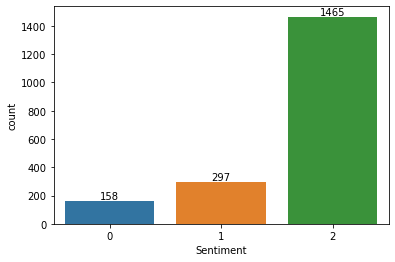

In [4]:
ax= sns.countplot('Sentiment', data= df)
ax.bar_label(container= ax.containers[0],labels=df['Sentiment'].value_counts(ascending=True))
plt.show()


## Preprocessing df_processing_2

In [5]:
# Drop Sentiment data that is equal to 2 to make the data more balanced
df_processing_2 = df[df["Sentiment"] == 2]
df_processing_2.reset_index(drop=True, inplace=True)
df = df[df["Sentiment"] != 2]
df_processing_2.drop(index=range(0, 1000), inplace=True)
df = pd.concat([df, df_processing_2], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

/Users/hungchichen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
df= df[['Review','Sentiment']]
df.shape

(920, 2)

In [7]:
# Split the dataframe to train and valid
train, valid=train_test_split(df, test_size=0.2, random_state= 0)
train.to_csv('train.csv')
valid.to_csv('valid.csv')

In [8]:
train_csv= pd.read_csv('train.csv',index_col=0)
valid_csv= pd.read_csv('valid.csv',index_col=0)
print(train_csv.shape)
print(valid_csv.shape)


(736, 2)
(184, 2)


## Assign train and valid sets

In [9]:
X_train = train_csv['Review']
y_train = train_csv['Sentiment']
X_valid = valid_csv['Review']
y_valid = valid_csv['Sentiment']

print(y_train.value_counts())

2    374
1    240
0    122
Name: Sentiment, dtype: int64


## CountVectorizer

In [10]:
count_vect = CountVectorizer(stop_words= 'english')
X_train_counts = count_vect.fit_transform(X_train.values)
X_test_counts= count_vect.transform(X_valid.values)

## TF-IDF


In [11]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## MultinomialNB


In [12]:
MNB = MultinomialNB().fit(X_train_tfidf, y_train)
MNB_pred = MNB.predict(X_test_tfidf)
print('accuracy_score', accuracy_score(y_valid, MNB_pred))
print('f1_score', f1_score(y_valid, MNB_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, MNB_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))

accuracy_score 0.5652173913043478
f1_score 0.3480589022757697
             negative(a)  neutral(a)  positive(a)
negative(p)            0          13           23
neutral(p)             0          13           44
positive(p)            0           0           91


## Build MNB Pipeline


In [13]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

## Hyper-Peram Tuning


In [14]:
parameters = {
    'vect__ngram_range': [(1, 1),(1, 2), (1, 3)],
    'vect__min_df': [0,1],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.01, 0.001, 0.1),
    'clf__fit_prior': (True, False),
}



gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf_pred =gs_clf.predict(X_valid)
print('best_params', gs_clf.best_params_)
print('best_score', gs_clf.best_score_)

# print(accuracy_score(y_valid, gs_clf_pred))
# print(confusion_matrix(y_valid, gs_clf_pred))

best_params {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__use_idf': False, 'vect__min_df': 0, 'vect__ngram_range': (1, 1)}
best_score 0.7377367163081449


## Adjusting Hyper Perameters

In [15]:
# count_vect = CountVectorizer(stop_words= 'english',min_df=0, ngram_range= (1,1) )
# X_train_counts = count_vect.fit_transform(X_train.values)
# X_test_counts= count_vect.transform(X_valid.values)

# tfidf_transformer = TfidfTransformer(use_idf=False)
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# MNB = MultinomialNB(alpha= 0.01, fit_prior=False ).fit(X_train_tfidf, y_train)
# MNB_pred = MNB.predict(X_test_tfidf)

text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words= 'english',min_df=0, ngram_range= (1,1))),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('clf', MultinomialNB(alpha= 0.01, fit_prior=False)),
])

text_clf.fit(X_train, y_train)
MNB_pipeline_pred= text_clf.predict(X_valid)

print('accuracy_score', accuracy_score(y_valid, MNB_pipeline_pred))
print('f1_score', f1_score(y_valid, MNB_pipeline_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, MNB_pipeline_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))




accuracy_score 0.6956521739130435
f1_score 0.6445237058535276
             negative(a)  neutral(a)  positive(a)
negative(p)           16          17            3
neutral(p)             6          33           18
positive(p)            0          12           79


## Print MNB Results


In [16]:
print("Accuracy", accuracy_score(y_valid, MNB_pipeline_pred))
print("Average F1 score", f1_score(y_valid, MNB_pipeline_pred, average="macro"))
print("Class-wise F1 scores:")
print("\tnegative:", f1_score(y_valid, MNB_pipeline_pred, average=None)[0])
print("\tneutral:", f1_score(y_valid, MNB_pipeline_pred, average=None)[1])
print("\tpositive:", f1_score(y_valid, MNB_pipeline_pred, average=None)[2])
print(
    "Confusion_matrix:\n ",
    pd.DataFrame(
        confusion_matrix(y_valid, MNB_pipeline_pred)
        / confusion_matrix(y_valid, MNB_pipeline_pred).astype(float).sum(),
        index=['negative(p)', 'neutral(p)' ,'positive(p)'],
        columns=['negative(a)', 'neutral(a)' ,'positive(a)'],
    ),
)

Accuracy 0.6956521739130435
Average F1 score 0.6445237058535276
Class-wise F1 scores:
	negative: 0.5517241379310345
	neutral: 0.5546218487394958
	positive: 0.8272251308900523
Confusion_matrix:
               negative(a)  neutral(a)  positive(a)
negative(p)     0.086957    0.092391     0.016304
neutral(p)      0.032609    0.179348     0.097826
positive(p)     0.000000    0.065217     0.429348


## CountVectorizer

In [17]:
count_vect = CountVectorizer(stop_words= 'english')
X_train_counts = count_vect.fit_transform(X_train.values)
X_test_counts= count_vect.transform(X_valid.values)

## TF-IDF


In [18]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## SGD


In [19]:
SGD_clf = SGDClassifier().fit(X_train_tfidf, y_train)
SGD_gs_clf_pred = SGD_clf.predict(X_test_tfidf)
print('accuracy_score', accuracy_score(y_valid, SGD_gs_clf_pred))
print('Average F1 score', f1_score(y_valid, SGD_gs_clf_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, SGD_gs_clf_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))



accuracy_score 0.6847826086956522
Average F1 score 0.635857329067425
             negative(a)  neutral(a)  positive(a)
negative(p)           16          14            6
neutral(p)             6          32           19
positive(p)            0          13           78


## Build SGD Pipeline


In [20]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words= 'english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])


## Hyper-Peram Tuning

In [21]:
parameters = {
    'vect__ngram_range': [(1, 2)],
    'vect__min_df': [0,1],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.01, 0.001),
    'clf__loss': ('hinge', 'modified_huber'), 
    'clf__penalty': ('l1', 'l2')
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
SGD_gs_clf_pred= gs_clf.predict(X_valid)
print('best_params', gs_clf.best_params_)
print('best_score', gs_clf.best_score_)


best_params {'clf__alpha': 0.001, 'clf__loss': 'modified_huber', 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__min_df': 0, 'vect__ngram_range': (1, 2)}
best_score 0.7174296745725317


## Adjusting Hyper Perameters

In [22]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words= 'english',min_df=1, ngram_range= (1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(alpha= 0.001, loss='hinge', penalty= 'l2'))
])
text_clf.fit(X_train, y_train)
SGD_pipeline_pred= text_clf.predict(X_valid)

print('accuracy_score', accuracy_score(y_valid, SGD_pipeline_pred))
print('f1_score', f1_score(y_valid, SGD_pipeline_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, SGD_pipeline_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))



accuracy_score 0.7282608695652174
f1_score 0.6452564102564102
             negative(a)  neutral(a)  positive(a)
negative(p)           12          18            6
neutral(p)             2          33           22
positive(p)            0           2           89


## Print SGD Results


In [23]:
print("Accuracy", accuracy_score(y_valid, SGD_pipeline_pred))
print("Average F1 score", f1_score(y_valid, SGD_pipeline_pred, average="macro"))
print("Class-wise F1 scores:")
print("\tnegative:", f1_score(y_valid, SGD_pipeline_pred, average=None)[0])
print("\tneutral:", f1_score(y_valid, SGD_pipeline_pred, average=None)[1])
print("\tpositive:", f1_score(y_valid, SGD_pipeline_pred, average=None)[2])
print(
    "Confusion_matrix:\n ",
    pd.DataFrame(
        confusion_matrix(y_valid, SGD_gs_clf_pred)
        / confusion_matrix(y_valid, SGD_gs_clf_pred).astype(float).sum(),
        index=['negative(p)', 'neutral(p)' ,'positive(p)'],
        columns=['negative(a)', 'neutral(a)' ,'positive(a)'],
    ),
)

Accuracy 0.7282608695652174
Average F1 score 0.6452564102564102
Class-wise F1 scores:
	negative: 0.48
	neutral: 0.6
	positive: 0.8557692307692306
Confusion_matrix:
               negative(a)  neutral(a)  positive(a)
negative(p)     0.059783    0.103261     0.032609
neutral(p)      0.010870    0.173913     0.125000
positive(p)     0.000000    0.005435     0.489130


## SVC

In [24]:
svc = SVC().fit(X_train_tfidf, y_train)
SVC_pred = svc.predict(X_test_tfidf)
print('accuracy', accuracy_score(y_valid, SVC_pred))
print('Average F1 score', f1_score(y_valid, SVC_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, SVC_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))



accuracy 0.6521739130434783
Average F1 score 0.4625451139212607
             negative(a)  neutral(a)  positive(a)
negative(p)            1          24           11
neutral(p)             0          28           29
positive(p)            0           0           91


## Build SVC Pipeline


In [25]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())
])


## Hyper-Peram Tuning

In [26]:
parameters = {
    'vect__ngram_range': [(1, 1),(1, 2),(1, 3)],
    'vect__min_df': [0,1],
    'tfidf__use_idf': (True, False),
    'clf__kernel': ('poly', 'rbf', 'sigmoid'),
    'clf__gamma': ('scale', 'auto'),
    'clf__shrinking': (True, False),
    'clf__probability': (True, False),
    'clf__tol': (0.01, 0.001)
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
SVC_gs_clf_pred = gs_clf.predict(X_valid)
print('best_params', gs_clf.best_params_)
print('best_score', gs_clf.best_score_)

best_params {'clf__gamma': 'scale', 'clf__kernel': 'sigmoid', 'clf__probability': True, 'clf__shrinking': True, 'clf__tol': 0.01, 'tfidf__use_idf': True, 'vect__min_df': 0, 'vect__ngram_range': (1, 1)}
best_score 0.718753447324876


## Adjusting Hyper Perameters

In [27]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words= 'english',min_df=0, ngram_range= (1,1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SVC(tol= 0.01,probability= True, shrinking=True ,gamma='scale' ,kernel='sigmoid' )),
])

text_clf.fit(X_train, y_train)
SVC_pipeline_pred= text_clf.predict(X_valid)

print('accuracy_score', accuracy_score(y_valid, SVC_pipeline_pred))
print('f1_score', f1_score(y_valid, SVC_pipeline_pred, average= 'macro'))
print(pd.DataFrame(confusion_matrix(y_valid, SVC_pipeline_pred), index=['negative(p)', 'neutral(p)' ,'positive(p)'], columns=['negative(a)', 'neutral(a)' ,'positive(a)']))


accuracy_score 0.717391304347826
f1_score 0.604822774734279
             negative(a)  neutral(a)  positive(a)
negative(p)            8          21            7
neutral(p)             1          34           22
positive(p)            0           1           90


## Print SVC Results


In [28]:
print("Accuracy", accuracy_score(y_valid, SVC_pipeline_pred))
print("Average F1 score", f1_score(y_valid, SVC_pipeline_pred, average="macro"))
print("Class-wise F1 scores:")
print("\tnegative:", f1_score(y_valid, SVC_pipeline_pred, average=None)[0])
print("\tneutral:", f1_score(y_valid, SVC_pipeline_pred, average=None)[1])
print("\tpositive:", f1_score(y_valid, SVC_pipeline_pred, average=None)[2])
print(
    "Confusion_matrix:\n ",
    pd.DataFrame(
        confusion_matrix(y_valid, SVC_pipeline_pred)
        / confusion_matrix(y_valid, SVC_pipeline_pred).astype(float).sum(),
        index=['negative(p)', 'neutral(p)' ,'positive(p)'],
        columns=['negative(a)', 'neutral(a)' ,'positive(a)'],
    ),
)

Accuracy 0.717391304347826
Average F1 score 0.604822774734279
Class-wise F1 scores:
	negative: 0.3555555555555555
	neutral: 0.6017699115044247
	positive: 0.8571428571428571
Confusion_matrix:
               negative(a)  neutral(a)  positive(a)
negative(p)     0.043478    0.114130     0.038043
neutral(p)      0.005435    0.184783     0.119565
positive(p)     0.000000    0.005435     0.489130


## Conduct model selection


In [29]:
MNB_cv_score = cross_val_score(MNB, X_train_tfidf, y_train, cv=20, scoring="accuracy")
SGD_clf_cv_score = cross_val_score(
    SGD_clf, X_train_tfidf, y_train, cv=20, scoring="accuracy"
)
svc_cv_score = cross_val_score(svc, X_train_tfidf, y_train, cv=20, scoring="accuracy")

## Plot the results


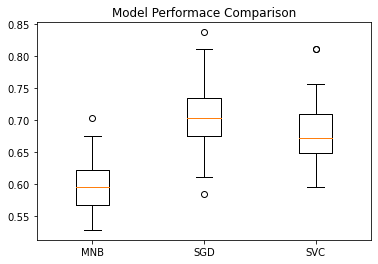

In [30]:
plt.boxplot([MNB_cv_score, SGD_clf_cv_score, svc_cv_score])
plt.title("Model Performace Comparison")
plt.xticks([1, 2, 3], ["MNB", "SGD", "SVC"])
plt.show()